## Three water molecule model testing

In [1]:
import torch
import math
import numpy as np
import dscribe
from ase.build import molecule
from dscribe.descriptors import SOAP
from ase.io import read, write
from ase import Atom, Atoms
import time
import os
import sys
import pickle
from ase.io.cube import read_cube, write_cube
from sklearn.metrics import explained_variance_score, mean_squared_error
import py3Dmol
sys.path.append('deepcdp/')
from deepcdp import deepcdp
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import pandas as pd
import sklearn.metrics as skmetrics
from sklearn.neural_network import MLPRegressor
import gc
import zipfile
import pandas as pd
from tqdm import tqdm
from ase.build import bulk
from ase.visualize.plot import plot_atoms

import datetime
import matplotlib.pyplot as plt
import random
import torch.utils.data as utils_data
from torch.autograd import Variable
from torch.nn.modules.dropout import Dropout

import warnings
warnings.filterwarnings('ignore')

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print("Device: ", device)

# This ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# This ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

Device:  mps
True
True


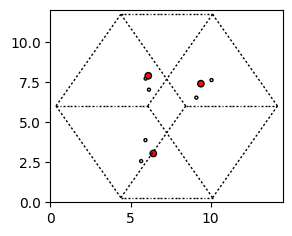

In [2]:
# generating an ASE Atoms object for Si
sample = read_cube(open('data/water3/h2o-ELECTRON_DENSITY-1_150.cube'))
ase=sample['atoms']
ase.set_pbc((True, True, True))
fig, ax = plt.subplots(figsize=(3,3))
plot_atoms(ase, ax, radii=0.3, rotation=('45x,45y,0z'))
plt.show()

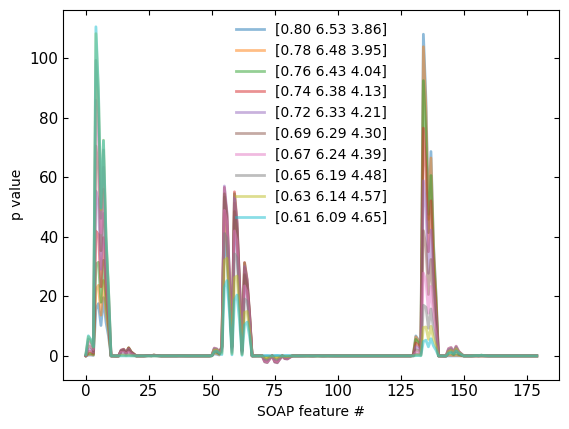

In [10]:
rcut = 9 # Local cut off
nmax = 4 # max number of radial basis functions
lmax = 4 # maximum degree of spherical harmonics

soap_W = SOAP( # W = with weighting
    species=['H','O'],
    rcut=rcut,
    nmax=nmax,
    lmax=nmax,
    sigma=1,
    periodic=True,
    sparse=False,
    weighting={"function":"poly","r0":2,"c":2,"m":2}
)

# Samping 10 points from first Si atom to the second Si atom
x1, y1, z1 = ase.get_positions()[0]
x2, y2, z2 = ase.get_positions()[1]
num_points = 10

x_values = np.linspace(x1, x2, num_points)
y_values = np.linspace(y1, y2, num_points)
z_values = np.linspace(z1, z2, num_points)

pos_vector = [(x, y, z) for x, y, z in zip(x_values, y_values, z_values)]

# generating soap for each point
soap = soap_W.create(ase, positions = pos_vector)

# plotting and storing the mean soap value
mean_soap = []
for i in range(len(pos_vector)):
    x,y,z=pos_vector[i]
    plt.plot(soap[i],
             label = f'[{x:1.2f} {y:1.2f} {z:1.2f}]',
            alpha=0.5,
            linewidth=2)
    mean_soap += [np.mean(soap[i])]
plt.xlabel('SOAP feature #')
plt.ylabel('p value')
# plt.xlim(0,50)
plt.legend(frameon=False)
plt.tick_params(direction = 'in', right = True, top = True)
plt.tick_params(axis='both', labelsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.show()

In [11]:
# Use the 6 DFT data points.
subsample=10

# Path of the file and filename prefix
datapath = 'data/water3/'
datafilename = 'h2o-ELECTRON_DENSITY-1_' 
all_files = os.listdir(f'{datapath}')
data_files =[x for x in all_files 
               if x.split('.')[-1] == 'cube']
idxList=[int(x.split('.cube')[0].split('_')[-1]) 
         for x in data_files if x.split('.')[-1] == 'cube']



cubefile = lambda x:f'{datapath}{x}' # creating a lambda function
print(idxList)
# generating an object of type deepcdp (imported)
CDP=deepcdp(soap_W)

# generates a box of points. Be mindful of the gamma value used.
CDP.create_box(sample_cubeFile=datapath+data_files[0], gamma=90)

totalfiles=int(os.popen(f'ls {datapath} | wc -l').read().split('\n')[0])

# useing ase's read_cube to read a sample cube file
dicttest=read_cube(open(datapath+data_files[0]))
sampleSubs=dicttest['atoms']
sampleSubs.set_pbc((True, True, True))

# randomly picking snapshots for training
data_files_sub = random.sample(data_files, k=subsample)

# generating final dataset
CDP.generate_cube_data(data_files_sub,cubefile,sampleSubs)


[1900, 1500, 50, 400, 1950, 200, 650, 700, 1250, 1600, 900, 2000, 150, 1200, 1850]
Read file: data/water3/h2o-ELECTRON_DENSITY-1_700.cube
SOAP is of dimension: (68921, 180)
Read file: data/water3/h2o-ELECTRON_DENSITY-1_1200.cube
Read file: data/water3/h2o-ELECTRON_DENSITY-1_1950.cube
Read file: data/water3/h2o-ELECTRON_DENSITY-1_50.cube
Read file: data/water3/h2o-ELECTRON_DENSITY-1_1500.cube
Read file: data/water3/h2o-ELECTRON_DENSITY-1_900.cube
Read file: data/water3/h2o-ELECTRON_DENSITY-1_2000.cube
Read file: data/water3/h2o-ELECTRON_DENSITY-1_400.cube
Read file: data/water3/h2o-ELECTRON_DENSITY-1_1850.cube
Read file: data/water3/h2o-ELECTRON_DENSITY-1_200.cube


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([ 7.3996e-10, -1.6031e-08,  3.6198e-08, ...,  4.6821e-09,
         1.1404e-09,  2.8369e-10]))

In [12]:
soaps=Variable(torch.Tensor(CDP.trainX))
rhos=Variable(torch.Tensor(CDP.trainY))

In [13]:
# Define the model class

torch.manual_seed(1)

class NN(torch.nn.Module):        
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NN, self).__init__()
        hidden_1, hidden_2, hidden_3 = hidden_sizes
        layers = [
            nn.Linear(input_size, hidden_1),
#             nn.BatchNorm1d(hidden_1),
            nn.ReLU(),
            nn.Linear(hidden_1, hidden_2),
#             nn.BatchNorm1d(hidden_2),
            nn.ReLU(),
            nn.Linear(hidden_2, hidden_3),
#             nn.BatchNorm1d(hidden_3),
            nn.ReLU(),
            nn.Linear(hidden_3, output_size)
        ]
        
        self.layers = nn.Sequential(*layers)
        
#     def _init_weights(self, m):
#         for param in m.parameters():
#             nn.init.uniform_(param.data, -1, 1)
        

    def forward(self, A0):
        x = self.layers(A0)
        return x

In [14]:
batch_size=500
# Define the hyperparameters
num_epochs = 40
learning_rate = 1e-3

# Define the model and loss function
model = NN(soaps.shape[1], [300,300,300], 1).to(device)

# Defining loss function
criterion = nn.MSELoss() 

# Using the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate,
                             weight_decay=1e-4)

# Using a ReduceLROnPlateau scheduler on the loss function to tweak the LR.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode="min", 
                                                       factor=0.5, 
                                                       patience=2, 
                                                       verbose=True, 
                                                       threshold=0.01)


training_samples = utils_data.TensorDataset(soaps, rhos)
data_loader_trn = utils_data.DataLoader(training_samples, 
                                        batch_size=batch_size, 
                                        drop_last=False, 
                                        shuffle=True)

In [15]:
# Train the model
cum_loss_epoch=[]
for epoch in range(num_epochs):
    batch_bar = tqdm(total=len(data_loader_trn), dynamic_ncols=True, leave=False, position=0, desc='Train') 
    model.train()
    cum_loss = 0
    # Convert inputs and labels to tensors
    
    for batch_idx, (data, target) in enumerate(data_loader_trn):
        inputs = (data.float()).to(device)
        labels = (target.float()).reshape(-1,1).to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cum_loss+=loss.item()
        batch_bar.set_postfix(
            loss="{:.04f}".format(cum_loss),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        batch_bar.update()
    batch_bar.close()
    print("Epoch {}/{}: Train Loss {:.04f}, Learning Rate {:.04f}".format(
        epoch + 1,
        num_epochs,
        float(cum_loss), 
        float(float(optimizer.param_groups[0]['lr']))
        ))

    scheduler.step(cum_loss)
    cum_loss_epoch +=[cum_loss]
    np.savetxt('sample-models/water3/cum_loss.dat',cum_loss_epoch)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {cum_loss:.4f}')
        plt.plot(model(soaps.to(device)).cpu().detach().numpy())
        plt.plot(rhos, alpha=0.5)
        plt.show()

    if (epoch+1)%2==0:
        model.eval()
        acc=skmetrics.r2_score(model(soaps.to(device)).cpu().detach().numpy(),rhos)
        print(f"Training R2 value: {acc:1.4f}")
        
    if (epoch+1) % 5 == 0:
        
        print('Saving model')
        torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict' : scheduler.state_dict(),
    }, f"sample-models/water3/water-"+str(epoch)+".pt")
#     print()

Epoch 1/40: Train Loss 0.2167, Learning Rate 0.0010


Epoch 2/40: Train Loss 0.1343, Learning Rate 0.0010
Training R2 value: 0.9623


Epoch 3/40: Train Loss 0.1307, Learning Rate 0.0010


Epoch 4/40: Train Loss 0.1230, Learning Rate 0.0010
Training R2 value: 0.9675


Epoch 5/40: Train Loss 0.1219, Learning Rate 0.0010
Saving model


Epoch 6/40: Train Loss 0.1223, Learning Rate 0.0010
Training R2 value: 0.9635


Epoch 7/40: Train Loss 0.1160, Learning Rate 0.0010


Epoch 8/40: Train Loss 0.1189, Learning Rate 0.0010
Training R2 value: 0.9661


Epoch 9/40: Train Loss 0.1189, Learning Rate 0.0010


Train:  18%|███▉                  | 247/1379 [00:04<00:21, 52.19it/s, loss=0.0263, lr=0.0010]

In [ ]:
model.eval()
# Testing 0 Cu structure
test_cube_path = 'data/water3/h2o-ELECTRON_DENSITY-1_1950.cube'
test_cube = read_cube(open(test_cube_path))
ase_atoms_test = test_cube['atoms']
ase_atoms_test.set_pbc((True, True, True))
pos_atoms_test = ase_atoms_test.get_positions()
rho_test = test_cube['data']
rho_test = rho_test.ravel().reshape(-1,1)

start = time.time()
soap_test = soap_W.create(ase_atoms_test, positions=CDP.box)
rho_pred = model(torch.tensor(soap_test, dtype=torch.float32).to(device)).cpu().detach().numpy()

end = time.time()
print("Prediction time: ", (end - start), " seconds.")
print(f'R2 value: {skmetrics.r2_score(rho_test,rho_pred):1.2f}')
print(f'MSE value: {skmetrics.mean_squared_error(rho_test,rho_pred):1.5f}')


In [ ]:
out=open('example/predictions/water3/pred-1950-torch.cube','w+')
rho_test_resp = rho_pred.reshape(*CDP.bounds)
write_cube(out,ase_atoms_test,rho_test_resp,origin=CDP.box[0])

In [ ]:
si_cube_predict=open('example/predictions/water3/pred-1950-torch.cube').read()
si_cube_dft=open(test_cube_path).read()
CDP.cube2xyz(test_cube_path,'example/structures/water3/water-1950.xyz')
isoval=0.1
xyz=open('example/structures/water3/water3-1950.xyz').read()
xyzview = py3Dmol.view(width=400,height=400)
xyzview.addVolumetricData(si_cube_predict,'cube',{'isoval': isoval,"color":'red','opacity':1,'wireframe':True})
xyzview.addVolumetricData(si_cube_dft,'cube',{'isoval': isoval,"color":'grey','opacity':1,'wireframe':True})
xyzview.addModel(xyz,'xyz')
xyzview.setStyle({'stick':{}})
xyzview.zoomTo()
xyzview.show()

In [ ]:
rho_test_resp.shape
rho_test = test_cube['data']
error = np.abs(rho_test - rho_test_resp)
out=open('example/predictions/water3/pred-1950-torch.cube','w+')
write_cube(out,ase_atoms_test,error,origin=CDP.box[0])

In [ ]:
vmin = 0
vmax = 5.3
plt.subplot(131)
plt.imshow(np.trapz(rho_test, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('DFT')
plt.subplot(132)
plt.imshow(np.trapz(rho_test_resp, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('DeepCDP')
plt.subplot(133)
plt.imshow(np.trapz(error, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('Error')
plt.subplots_adjust(bottom=0.0, right=0.9, top=0.9)
cax = plt.axes([0.95, 0.3, 0.015, 0.3])
plt.colorbar(cax=cax)
# plt.savefig('Images/LiF-example.png',dpi=600,bbox_inches="tight",)